In [56]:
import numpy as np
import matplotlib.pyplot as plt 
import csv 
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [57]:
AMOUNT_OF_DATA = 365 * 5
DATA_USED_FOR_TESTING = .2
NUMBER_OF_NEURONS_IN_HIDDEN_LAYER = 10000
ACTIVATION_FUNCTION = 'logistic' # logistic, tanh
RMS_ERROR = .005
INIT_LEARNING_STEP = .05
NUMBER_OF_EPOCHS = 200

In [58]:
maxNumberOfNeuronsInHiddenLayers = AMOUNT_OF_DATA // 3

if NUMBER_OF_NEURONS_IN_HIDDEN_LAYER > maxNumberOfNeuronsInHiddenLayers:
    NUMBER_OF_NEURONS_IN_HIDDEN_LAYER = maxNumberOfNeuronsInHiddenLayers
    print(f'Number of neurons changed to maximum ({maxNumberOfNeuronsInHiddenLayers})')

maxNumberOfLines = 24837
if AMOUNT_OF_DATA > maxNumberOfLines:
    AMOUNT_OF_DATA = maxNumberOfLines
    print(f'Number of lines changed to maximum ({maxNumberOfLines})')

Number of neurons changed to maximum (608)


In [59]:
plt.rcParams['figure.figsize'] = [12, 5] 
plt.rcParams['lines.markersize'] = 2

In [60]:
def smooth(scalars, weight): 
    last = scalars[0] 
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)                      
        last = smoothed_val                                
        
    return smoothed

In [61]:
def word_declension(n, forms):
    if n % 10 == 1 and n % 100 != 11:
        return forms[0]
    elif n % 10 >= 2 and n % 10 <= 4 and (n % 100 < 10 or n % 100 >= 20):
        return forms[1]
    else:
        return forms[2]

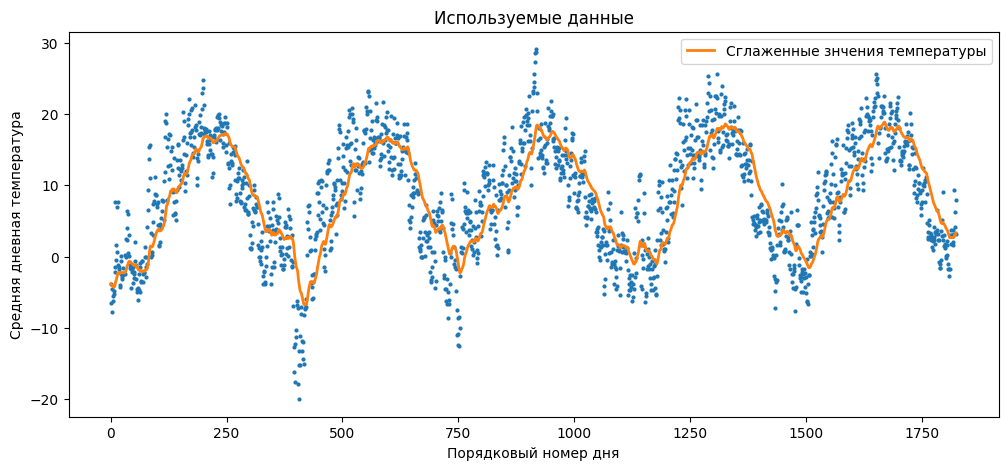

In [62]:
featureDays = []
featureMeanTemp = []
with open('weatherdata.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',')
    for i, row in enumerate(plots):
        if i == AMOUNT_OF_DATA: break
        featureDays.append(i % 365)
        featureMeanTemp.append(float(row[1]))

x = np.linspace(0, AMOUNT_OF_DATA, num=AMOUNT_OF_DATA, endpoint=True)

smoothedMeanTemp = smooth(featureMeanTemp, .96)

plt.plot(x, featureMeanTemp, 'o', markersize = 2)
plt.plot(x, smoothedMeanTemp, '-', linewidth = 2, label='Сглаженные знчения температуры')
plt.title('Используемые данные')
plt.xlabel('Порядковый номер дня')
plt.ylabel('Средняя дневная температура')
plt.legend()
plt.show()


In [63]:
minMaxScaler = MinMaxScaler(feature_range=(0, 1))
minMaxRescaledFeatureDays = minMaxScaler.fit_transform([[day] for day in featureDays])

np.set_printoptions(precision=4)
print(minMaxRescaledFeatureDays[:6,:])

[[0.    ]
 [0.0027]
 [0.0055]
 [0.0082]
 [0.011 ]
 [0.0137]]


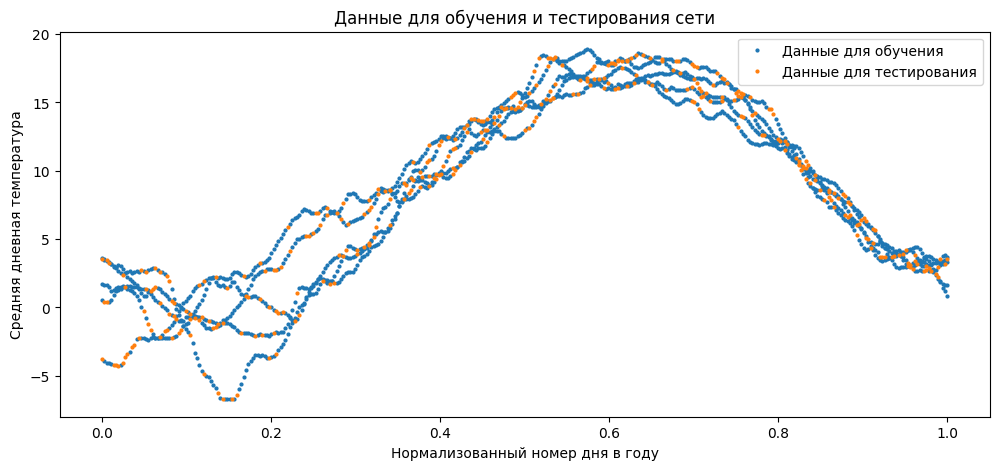

In [64]:
X_train, X_test, y_train, y_test = train_test_split(minMaxRescaledFeatureDays, smoothedMeanTemp, test_size=DATA_USED_FOR_TESTING, random_state=45)

plt.plot(X_train, y_train, 'o', label='Данные для обучения')
plt.plot(X_test, y_test, 'o', label='Данные для тестирования')
plt.xlabel('Нормализованный номер дня в году')
plt.ylabel('Средняя дневная температура')
plt.title('Данные для обучения и тестирования сети')
plt.legend()
plt.show()

In [65]:
%%time
model = MLPRegressor(hidden_layer_sizes=(NUMBER_OF_NEURONS_IN_HIDDEN_LAYER,), 
                     activation=ACTIVATION_FUNCTION, solver='adam', 
                     epsilon=RMS_ERROR, learning_rate_init=INIT_LEARNING_STEP, 
                     max_iter=200, warm_start=True)

mse_list = []
for i in range(NUMBER_OF_EPOCHS): 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)

CPU times: total: 15.2 s
Wall time: 27.4 s


Функция активации: сигмоида
Количество нейронов скрытого слоя: 608
Количество используемых данных: 5 лет
Количество данных использованных для тестирования: 20.0%
Среднеквадратичная ошибка: 3.27303


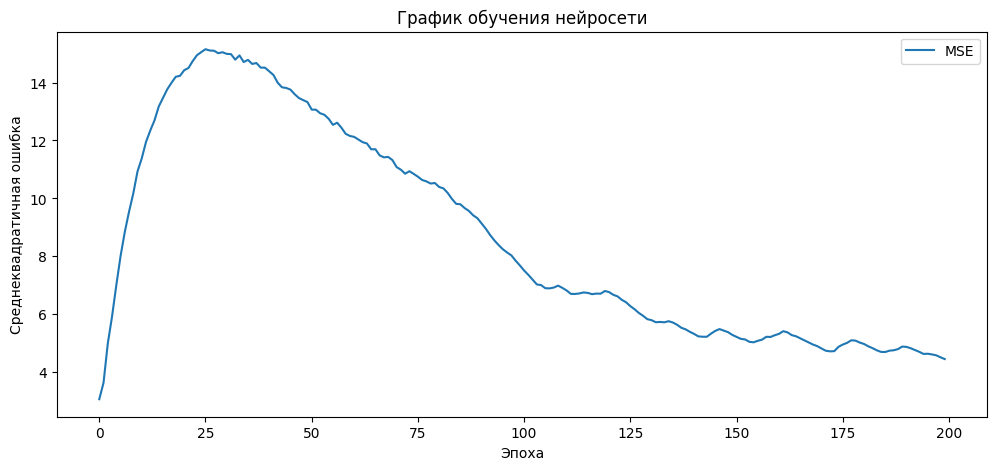

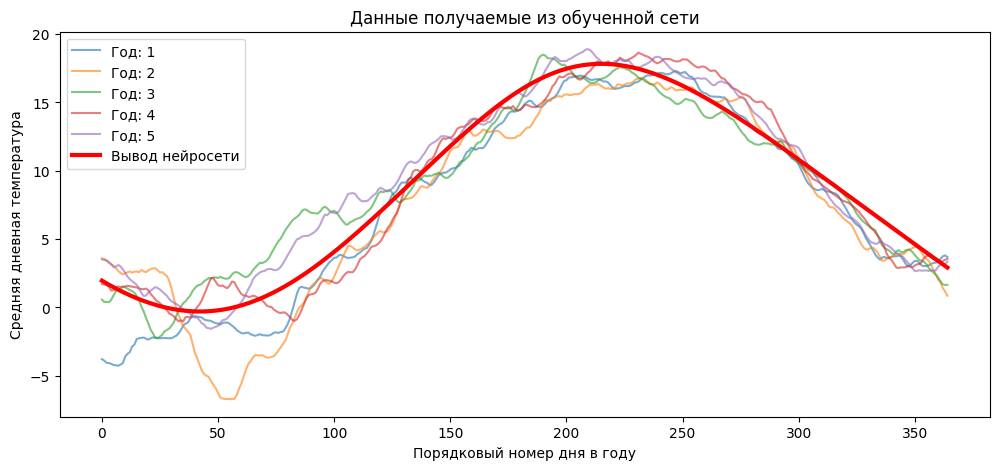

In [66]:
print(f'Функция активации: {"сигмоида" if ACTIVATION_FUNCTION == "logistic" else "гиперболический тангенс"}')
print(f'Количество нейронов скрытого слоя: {NUMBER_OF_NEURONS_IN_HIDDEN_LAYER}')
print(f'Количество используемых данных: {AMOUNT_OF_DATA // 365} {word_declension(AMOUNT_OF_DATA // 365, ["год", "года", "лет"])}')
print(f'Количество данных использованных для тестирования: {DATA_USED_FOR_TESTING * 100}%')
print(f'Среднеквадратичная ошибка: {round(mse, 5)}')

plt.plot(smooth(mse_list, .95), label='MSE')
plt.xlabel('Эпоха')
plt.ylabel('Среднеквадратичная ошибка')
plt.title('График обучения нейросети')
plt.legend()
plt.show()

xi = []
yi = []
for i in range(365):
    xi.append(i)
    yi.append(model.predict(minMaxScaler.transform([[i]]))[0])

for i in range(0, len(featureDays), 365):
    plt.plot(featureDays[i:i + 365], smoothedMeanTemp[i : i + 365], label=f'Год: {i//365 + 1}', alpha=.6)
plt.plot(xi, yi, '-', c='red', label='Вывод нейросети', linewidth=3)
plt.xlabel('Порядковый номер дня в году')
plt.ylabel('Средняя дневная температура')
plt.title('Данные получаемые из обученной сети')
plt.legend()
plt.show()  
    